In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score, confusion_matrix

# Regression problem

## Loading dataset
Load the Boston Housing dataset from the Keras library.

Due to the ethical issues surrounding the Boston housing dataset, primarily the inclusion of a racist feature engineered by the dataset's authors, the Boston housing dataset will not be used. Alternatively, the California housing dataset, available in SKlearn, will be used instead.

In [132]:
ca_housing = fetch_california_housing(as_frame=True)

In [133]:
feature_df = ca_housing.data
target_df = ca_housing.target

## Explore and preprocess
Explore and preprocess the data (e.g., normalization, one-hot encoding, etc.).

In [134]:
(num_samples, num_features) = feature_df.shape

print(f'Sample size: {num_samples}')
print(f'Number of features: {num_features}')

Sample size: 20640
Number of features: 8


In [135]:
# concatenate all train and test data and targets together
full_df = pd.concat([feature_df, target_df], axis=1)

In [136]:
full_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


### Correlation Matrix

In [137]:
correlation_matrix = full_df.corr()

corr_w_target = correlation_matrix['MedHouseVal']

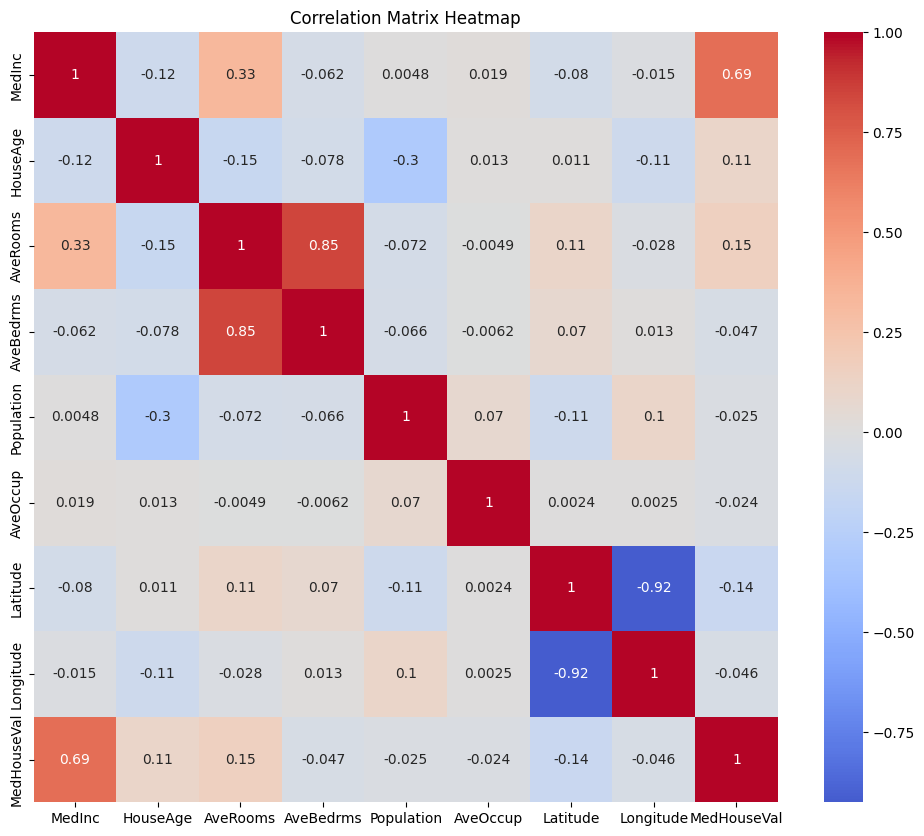

In [138]:
plt.figure(figsize=(12,10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix Heatmap')
plt.show()

In [139]:
print(f'Correlations with the target variable:\n{corr_w_target}')

Correlations with the target variable:
MedInc         0.688075
HouseAge       0.105623
AveRooms       0.151948
AveBedrms     -0.046701
Population    -0.024650
AveOccup      -0.023737
Latitude      -0.144160
Longitude     -0.045967
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64


### Feature histplots

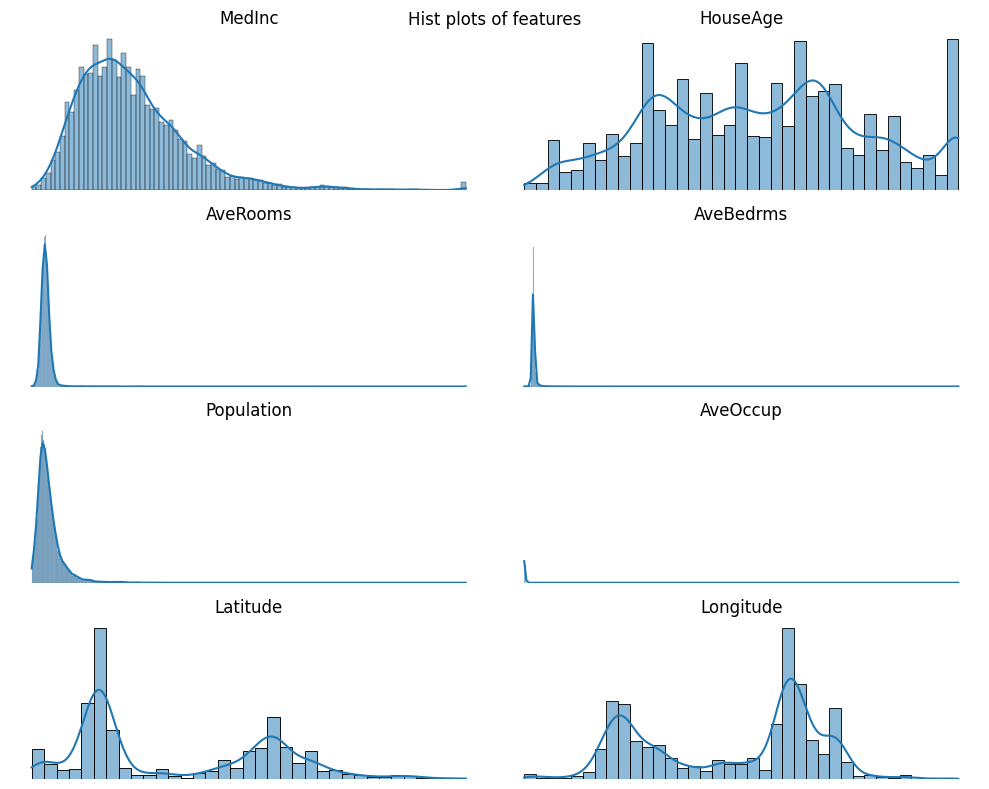

In [140]:
num_rows = 4
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,8))
fig.subplots_adjust(hspace=0.5)

for i in range(num_features):
    row_idx = i // num_cols
    col_idx = i % num_cols

    sns.histplot(feature_df.iloc[:,i], ax=axes[row_idx, col_idx], kde=True)
    axes[row_idx, col_idx].set_title(f'{feature_df.columns[i]}')

    if i >= num_features - (num_rows * num_cols):
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.suptitle('Hist plots of features')
plt.show()

### Feature boxplots

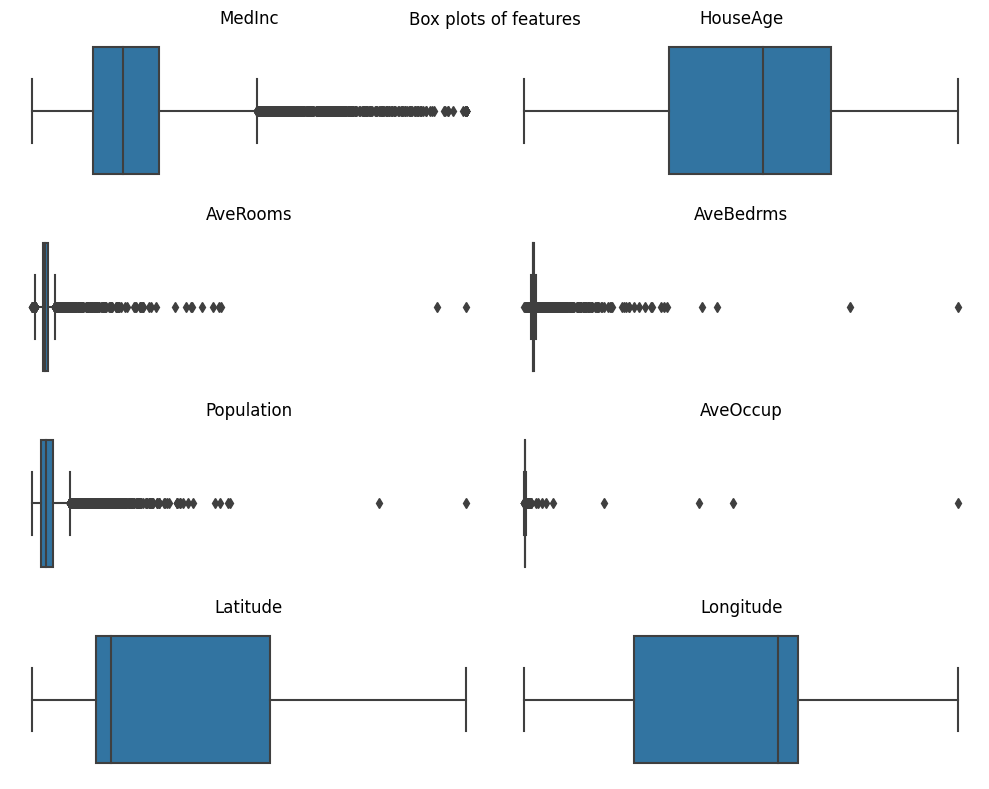

In [141]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,8))
fig.subplots_adjust(hspace=0.5)

for i in range(num_features):
    row_idx = i // num_cols
    col_idx = i % num_cols

    sns.boxplot(x=feature_df.iloc[:,i], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'{feature_df.columns[i]}')

    if i >= num_features - (num_rows * num_cols):
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.suptitle('Box plots of features')
plt.show()

### Address significant outliers

In [142]:
full_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [143]:
full_df[full_df['AveRooms'] > 50]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1912,4.9750,16.0,56.269231,10.153846,54.0,2.076923,39.01,-120.16,2.06300
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06,4.37500
1914,1.8750,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10,5.00001
1979,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,1.62500
2395,3.8750,23.0,50.837838,10.270270,64.0,1.729730,37.12,-119.34,1.25000
9676,3.2431,14.0,52.848214,11.410714,265.0,2.366071,37.64,-119.02,2.21400
11707,1.1912,22.0,52.690476,8.857143,98.0,2.333333,39.15,-120.06,1.70000
11862,2.6250,25.0,59.875000,15.312500,28.0,1.750000,40.27,-121.25,0.67500
12447,1.6154,17.0,62.422222,14.111111,83.0,1.844444,33.97,-114.49,0.87500


In [144]:
# drop outliers, averooms 132 and 141 and AveBedrms 34 and 25
full_df = full_df.loc[full_df['AveRooms'] < 65]

In [145]:
full_df[full_df['AveOccup'] > 50]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,0.675
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,1.546
12104,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33,1.625
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,2.250
16420,5.7485,26.0,5.366667,0.900000,1542.0,51.400000,37.89,-121.29,1.625
16669,4.2639,46.0,9.076923,1.307692,6532.0,502.461538,35.32,-120.70,3.500
19006,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98,1.375


In [146]:
# drop outliers, aveoccup 100+
full_df = full_df.loc[full_df['AveOccup'] < 100]

In [147]:
full_df[full_df['Population'] > 20000]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
9880,2.3087,11.0,5.364518,1.059684,28566.0,4.696810,36.64,-121.79,1.188
15360,2.5729,14.0,5.270497,1.010484,35682.0,7.482072,33.35,-117.42,1.344


In [148]:
# drop outliers, population 20k+
full_df = full_df.loc[full_df['Population'] < 20000]

### New boxplots with significant outliers removed

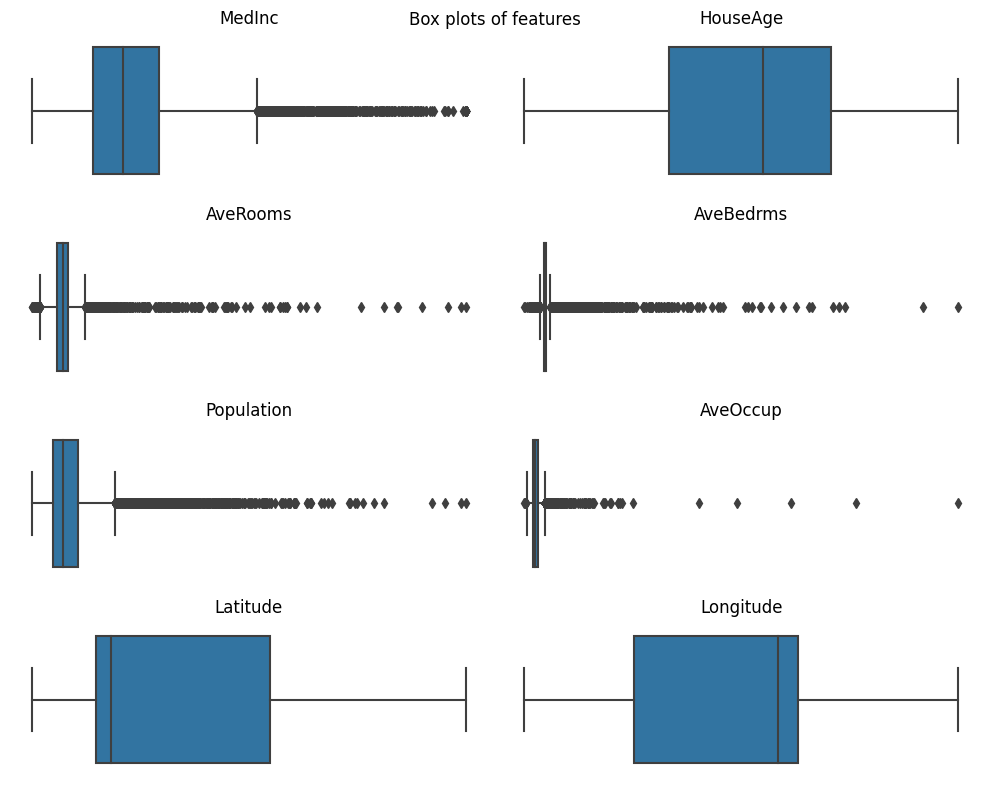

In [149]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,8))
fig.subplots_adjust(hspace=0.5)

for i in range(num_features):
    row_idx = i // num_cols
    col_idx = i % num_cols

    sns.boxplot(x=full_df.iloc[:,i], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'{feature_df.columns[i]}')

    if i >= num_features - (num_rows * num_cols):
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.suptitle('Box plots of features')
plt.show()

## TTS
Split the data into training and testing sets.

In [150]:
X = full_df.drop(['MedHouseVal'], axis=1)
y = full_df['MedHouseVal']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)

### Feature and target scaling

In [152]:
scaler_x = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [153]:
scaler_y = MinMaxScaler()

y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)
y_train_arr = y_train_arr.reshape(-1, 1)
y_test_arr = y_test_arr.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_arr)
y_test_scaled = scaler_y.transform(y_test_arr)

## Model definition
Define a deep neural network architecture for regression using Keras.

In [154]:
def create_regression_model(optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [155]:
baseline_regression_model = create_regression_model()

## Model training and testing
Train the model on the training set and evaluate its performance on the testing set.

### Model training

In [156]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('baseline_regression.h5', save_best_only=True)

history = baseline_regression_model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


413/413 [==============================] - 1s 1ms/step - loss: 0.0303 - mae: 0.1283 - val_loss: 0.0211 - val_mae: 0.1062
Epoch 2/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0235 - mae: 0.1111 - val_loss: 0.0186 - val_mae: 0.0951
Epoch 3/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0204 - mae: 0.1026 - val_loss: 0.0162 - val_mae: 0.0897
Epoch 4/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0187 - mae: 0.0975 - val_loss: 0.0153 - val_mae: 0.0865
Epoch 5/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0177 - mae: 0.0943 - val_loss: 0.0144 - val_mae: 0.0853
Epoch 6/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0172 - mae: 0.0929 - val_loss: 0.0142 - val_mae: 0.0855
Epoch 7/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0164 - mae: 0.0902 - val_loss: 0.0179 - val_mae: 0.1053
Epoch 8/50
413/413 [==============================] - 0s 1ms/step - loss: 0.0163 - mae:

### Baseline training perf

In [157]:
def training_plots(history, metric):
    """
    Function to plot training and validation history for a given metric
    inputs: history - model training history
            metric - desired metric for plotting
    returns: -
    """
    epochs = len(history.history[f'{metric}'])
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=range(1, epochs + 1), y=history.history[f'{metric}'], label=f'Training {metric}')
    sns.lineplot(x=range(1, epochs + 1), y=history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric}')
    plt.title(f'Training and Validation {metric}')
    plt.legend()
    plt.show()

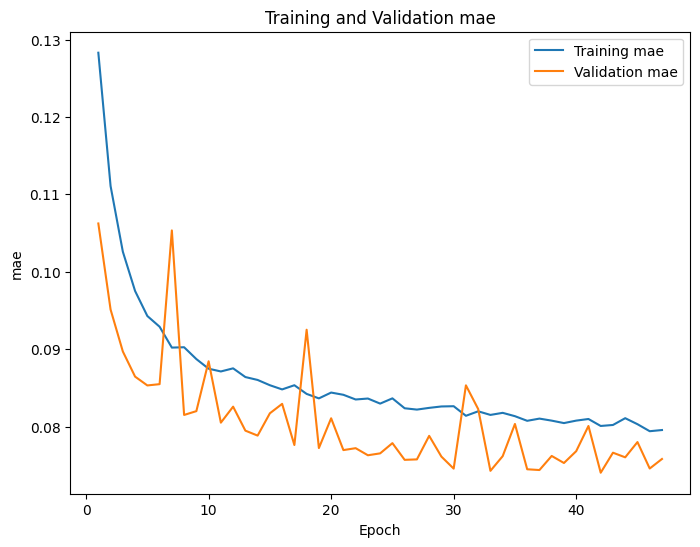

In [158]:
training_plots(history, 'mae')

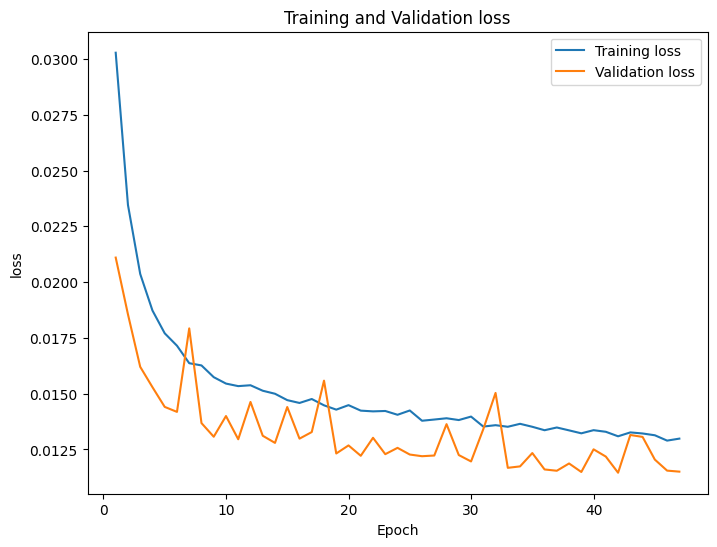

In [159]:
training_plots(history, 'loss')

### Basemodel performance in testing

In [160]:
loss, mae = baseline_regression_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test MAE: {mae:.4f}')

Test Loss: 0.0123
Test MAE: 0.0757


In [161]:
y_pred = baseline_regression_model.predict(X_test_scaled)
y_pred_inv = scaler_y.inverse_transform(y_pred)

129/129 [==============================] - 0s 571us/step


In [162]:
def testing_plot(y_true, y_pred, tuned=0):
    """
    Function to scatterplot testing performance of a regression model
    Inputs: y_true - Actual targets
            y_pred - Model predicted targets
            tuned - parameter to allow for plotting of 2 scatterplots
    Returns: -
    """
    if tuned:
        plt.scatter(y_true, y_pred, color='green', label='Tuned model')
    else:
        plt.scatter(y_true, y_pred, color='blue', label='Baseline model')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('True vs Pred')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')

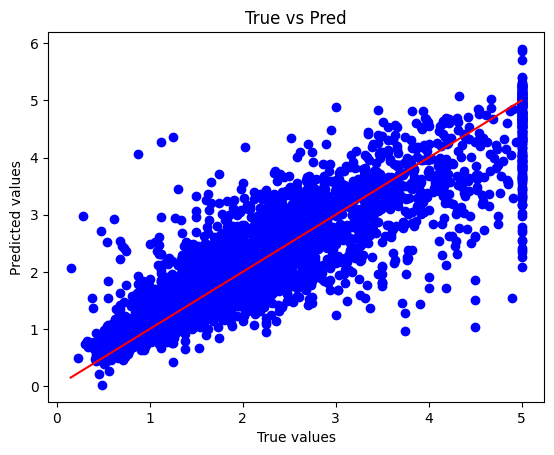

In [163]:
testing_plot(y_test, y_pred_inv)
plt.show()

## Parameter tuning
Tune the hyperparameters of the model to achieve better performance (e.g., number of hidden layers, activation functions, learning rate, number of epochs, etc.).

In [164]:
tuning_regression_model = KerasRegressor(build_fn=create_regression_model, verbose=0)

param_grid = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'epochs': [20, 50],
    'dropout_rate': [0.2, 0.3]
}

C:\Users\Reed Oken\AppData\Local\Temp\ipykernel_16472\1470353211.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  tuning_regression_model = KerasRegressor(build_fn=create_regression_model, verbose=0)


In [165]:
regressor_grid = GridSearchCV(estimator=tuning_regression_model, param_grid=param_grid, cv=3, n_jobs=-1)

grid_result = regressor_grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping])

In [166]:
gs_regression_df = pd.DataFrame(grid_result.cv_results_)
gs_regression_df = gs_regression_df.drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score'])

gs_regression_df = gs_regression_df.sort_values(by='rank_test_score', ascending=True)
gs_regression_df.head(20).round(4)

,param_activation,param_batch_size,param_dropout_rate,param_epochs,param_optimizer,mean_test_score,std_test_score,rank_test_score
10,relu,32,0.2,50,adam,-0.0125,0.0006,1
22,relu,64,0.3,50,adam,-0.0126,0.0004,2
6,relu,16,0.3,50,adam,-0.0128,0.0003,3
14,relu,32,0.3,50,adam,-0.0129,0.0007,4
18,relu,64,0.2,50,adam,-0.0130,0.0005,5
2,relu,16,0.2,50,adam,-0.0134,0.0006,6
8,relu,32,0.2,20,adam,-0.0136,0.0008,7
0,relu,16,0.2,20,adam,-0.0137,0.0016,8
12,relu,32,0.3,20,adam,-0.0140,0.0011,9
16,relu,64,0.2,20,adam,-0.0142,0.0008,10


## Model evaluation
Compare the performance of the tuned model with the baseline model (i.e., the initial model without any hyperparameter tuning).

In [167]:
# best params identified via grid search
activation = 'relu'
batch_size = 16
dropout_rate = 0.2
epochs = 50
optimizer = 'adam'

In [168]:
tuned_regression_model = create_regression_model(activation=activation, optimizer=optimizer, dropout_rate=dropout_rate)

In [169]:
model_checkpoint = ModelCheckpoint('tuned_regression.h5', save_best_only=True)

history = tuned_regression_model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


826/826 [==============================] - 1s 1ms/step - loss: 0.0295 - mae: 0.1259 - val_loss: 0.0203 - val_mae: 0.1015
Epoch 2/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0221 - mae: 0.1071 - val_loss: 0.0238 - val_mae: 0.1037
Epoch 3/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0192 - mae: 0.0988 - val_loss: 0.0159 - val_mae: 0.0864
Epoch 4/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0177 - mae: 0.0947 - val_loss: 0.0147 - val_mae: 0.0903
Epoch 5/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0172 - mae: 0.0933 - val_loss: 0.0145 - val_mae: 0.0871
Epoch 6/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0165 - mae: 0.0908 - val_loss: 0.0138 - val_mae: 0.0850
Epoch 7/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0161 - mae: 0.0897 - val_loss: 0.0145 - val_mae: 0.0834
Epoch 8/50
826/826 [==============================] - 1s 1ms/step - loss: 0.0161 - mae:

### Tuned model training perf

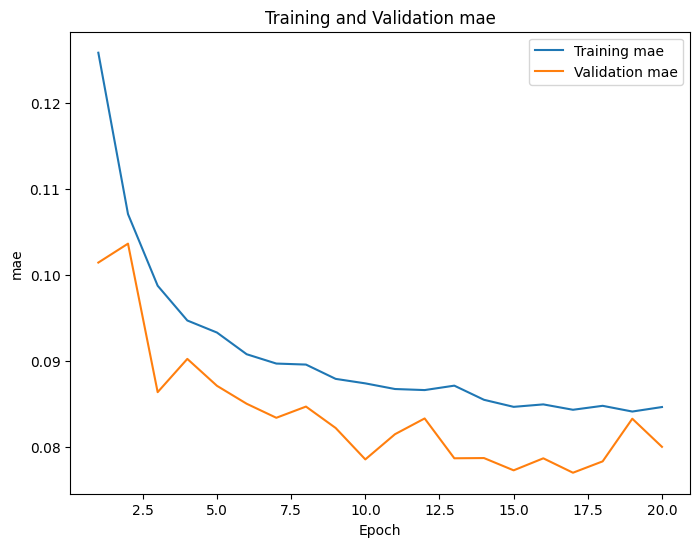

In [170]:
training_plots(history, 'mae')

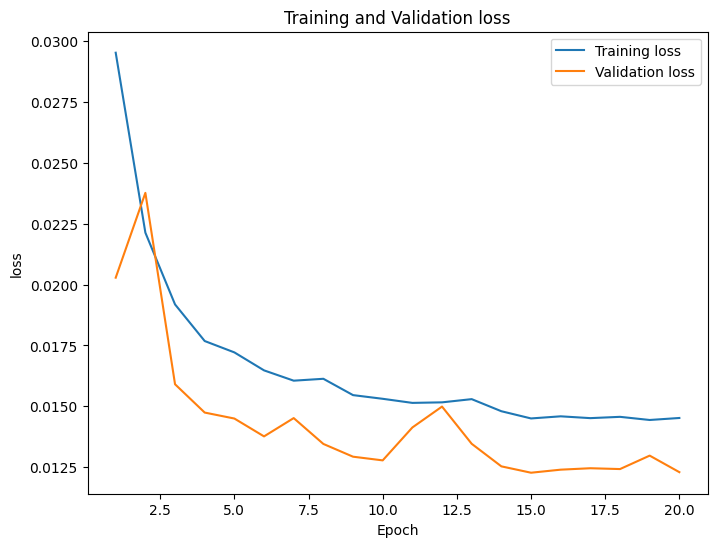

In [171]:
training_plots(history, 'loss')

### Tuned model testing perf

In [172]:
baseline_loss, baseline_mae = baseline_regression_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
tuned_loss, tuned_mae = tuned_regression_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'Baseline model test loss: {baseline_loss:.4f}')
print(f'Tuned model test loss: {tuned_loss:.4f}\n')

print(f'Baseline model test MAE: {baseline_mae:.4f}')
print(f'Tuned model test MAE: {tuned_mae:.4f}')

Baseline model test loss: 0.0123
Tuned model test loss: 0.0129

Baseline model test MAE: 0.0757
Tuned model test MAE: 0.0787


In [173]:
y_pred_baseline = baseline_regression_model.predict(X_test_scaled)
y_pred_tuned = tuned_regression_model.predict(X_test_scaled)

y_pred_baseline_inv = scaler_y.inverse_transform(y_pred_baseline)
y_pred_tuned_inv = scaler_y.inverse_transform(y_pred_tuned)

  1/129 [..............................] - ETA: 1s

129/129 [==============================] - 0s 585us/step


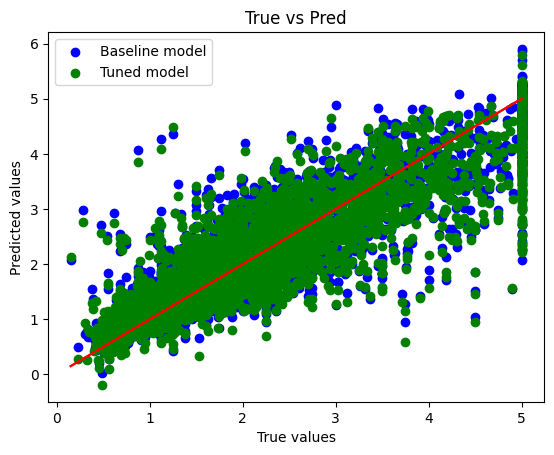

In [174]:
testing_plot(y_test, y_pred_baseline_inv)
testing_plot(y_test, y_pred_tuned_inv, tuned=1)
plt.legend()
plt.show()

# Classification problem

## Load data
Load the Boston Housing dataset from the Keras library.

No new data will be loaded as the data loaded for the regression problem is the same as the data required for the classification problem.

## EDA
Explore and preprocess the data (e.g., normalization, one-hot encoding, etc.).

EDA and preprocessing completed within the scope of the regression setup.

## Binary target
Convert the target variable into a binary variable (i.e., expensive or not expensive).

### Investigate the 'breakpoint' for expensive vs non-expensive

In [175]:
full_df['MedHouseVal'].describe()

count    20632.000000
mean         2.068538
std          1.153873
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

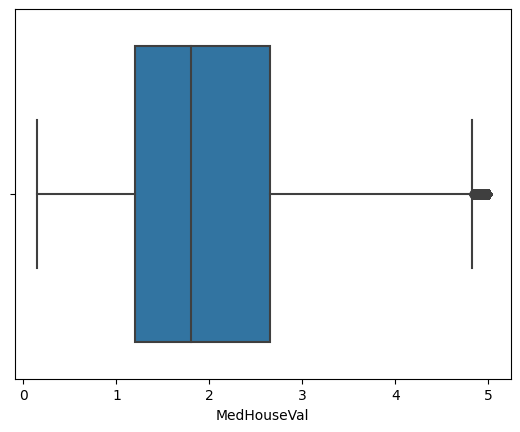

In [176]:
sns.boxplot(x=full_df['MedHouseVal'])
plt.show()

Expensive houses will be MedHouseVal > 3

In [177]:
# create new binary target 'expensive'
expensive = 3

full_df['expensive'] = full_df['MedHouseVal'].apply(lambda x: 1 if x > expensive else 0)

## TTS
Split the data into training and testing sets.

In [178]:
X = full_df.drop(['MedHouseVal', 'expensive'], axis=1)
y = full_df['expensive']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)

### Feature scaling

In [180]:
scaler_x = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

## Define model
Define a deep neural network architecture for classification using Keras.

In [181]:
def create_classification_model(optimizer='adam', activation='relu', dropout_rate=0.2):
    """
    Function to create a DNN classifier
    Inputs: Optimizer - model optimizer, default: adam
            actiavtion - activation function for hidden layers, default: relu
            dropout_rate - dropout rate for hidden layer, default: 0.2
    Returns: compiled model
    """
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Train and test model
Train the model on the training set and evaluate its performance on the testing set.

In [182]:
baseline_classification_model = create_classification_model()

In [183]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('baseline_regression.h5', save_best_only=True)

history = baseline_classification_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


413/413 [==============================] - 1s 1ms/step - loss: 0.3683 - accuracy: 0.8509 - val_loss: 0.2877 - val_accuracy: 0.8843
Epoch 2/50
413/413 [==============================] - 0s 1ms/step - loss: 0.2974 - accuracy: 0.8807 - val_loss: 0.2733 - val_accuracy: 0.8949
Epoch 3/50
413/413 [==============================] - 0s 1ms/step - loss: 0.2912 - accuracy: 0.8828 - val_loss: 0.2638 - val_accuracy: 0.8964
Epoch 4/50
413/413 [==============================] - 1s 1ms/step - loss: 0.2817 - accuracy: 0.8856 - val_loss: 0.2614 - val_accuracy: 0.8973
Epoch 5/50
413/413 [==============================] - 0s 1ms/step - loss: 0.2763 - accuracy: 0.8863 - val_loss: 0.2476 - val_accuracy: 0.9003
Epoch 6/50
413/413 [==============================] - 1s 1ms/step - loss: 0.2680 - accuracy: 0.8912 - val_loss: 0.2440 - val_accuracy: 0.9018
Epoch 7/50
413/413 [==============================] - 0s 1ms/step - loss: 0.2595 - accuracy: 0.8919 - val_loss: 0.2412 - val_accuracy: 0.9006
Epoch 8/50
413/41

### Baseline training progression plots

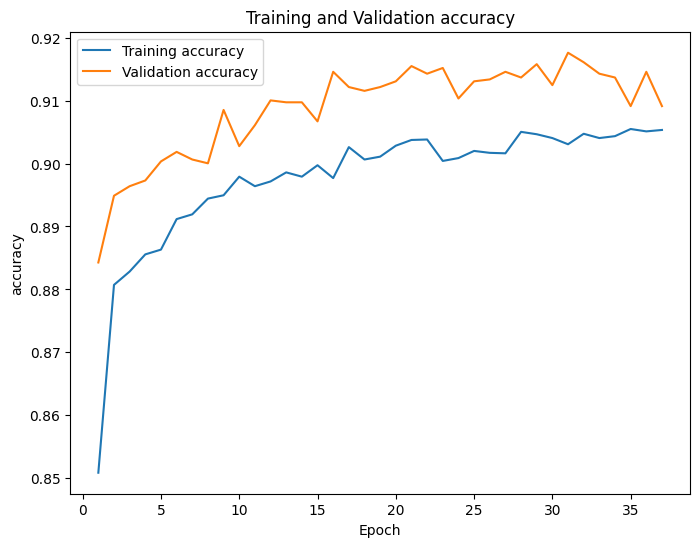

In [184]:
training_plots(history, 'accuracy')

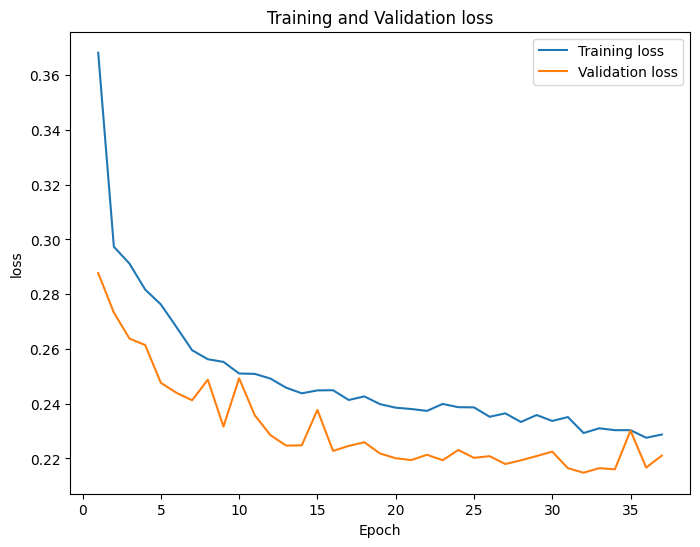

In [185]:
training_plots(history, 'loss')

### Baseline testing performance

In [186]:
loss, accuracy = baseline_classification_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Test Loss: 0.2132
Test accuracy: 0.9159


In [187]:
predictions = baseline_classification_model.predict(X_test_scaled)
threshold = 0.5
y_pred_baseline = np.where(predictions >= threshold, 1, 0)

129/129 [==============================] - 0s 580us/step


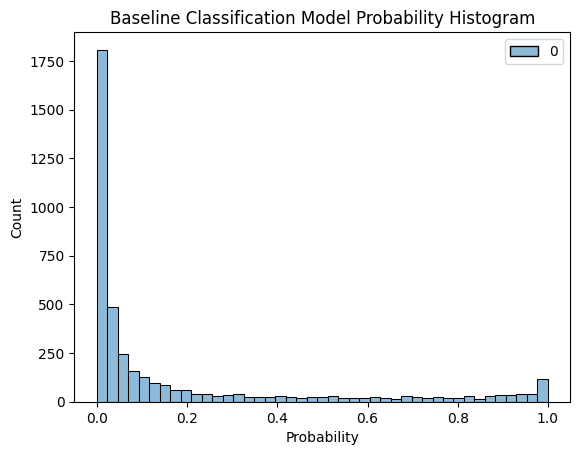

In [188]:
sns.histplot(predictions)
plt.title('Baseline Classification Model Probability Histogram')
plt.xlabel('Probability')
plt.show()

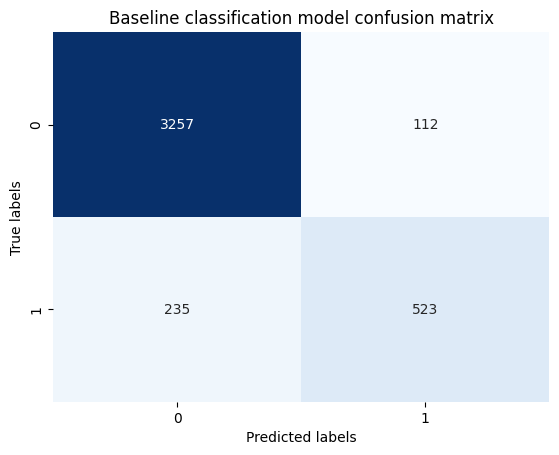

In [189]:
confusion_mat = confusion_matrix(y_test, y_pred_baseline)

sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Baseline classification model confusion matrix')
plt.show()

In [190]:
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)

In [191]:
print(f'Baseline classification model test accuracy: {baseline_acc:.4f}')
print(f'Baseline classification model test precision: {baseline_precision:.4f}')
print(f'Baseline classification model test recall: {baseline_recall:.4f}')
print(f'Baseline classification model test F1: {baseline_f1:.4f}')

Baseline classification model test accuracy: 0.9159
Baseline classification model test precision: 0.8236
Baseline classification model test recall: 0.6900
Baseline classification model test F1: 0.7509


## Parameter tuning
Tune the hyperparameters of the model to achieve better performance (e.g., number of hidden layers, activation functions, learning rate, number of epochs, etc.).

In [192]:
tuning_classification_model = KerasClassifier(build_fn=create_classification_model, verbose=0)

C:\Users\Reed Oken\AppData\Local\Temp\ipykernel_16472\3533025257.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  tuning_classification_model = KerasClassifier(build_fn=create_classification_model, verbose=0)


In [193]:
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'epochs': [20, 50],
    'dropout_rate': [0.2, 0.3]
}

In [194]:
classifier_grid = GridSearchCV(estimator=tuning_classification_model, param_grid=param_grid, cv=3, n_jobs=-1)

model_checkpoint = ModelCheckpoint('tuning_classification.h5', save_best_only=True)

In [195]:
grid_result = classifier_grid.fit(X_train_scaled, y_train, callbacks=[early_stopping], validation_split=0.2)

In [196]:
gs_classification_df = pd.DataFrame(grid_result.cv_results_)
gs_classification_df = gs_classification_df.drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score'])

gs_classification_df = gs_classification_df.sort_values(by='rank_test_score', ascending=True)
gs_classification_df.head(20).round(4)

,param_activation,param_batch_size,param_dropout_rate,param_epochs,param_optimizer,mean_test_score,std_test_score,rank_test_score
2,relu,16,0.2,50,adam,0.9068,0.0058,1
6,relu,16,0.3,50,adam,0.9052,0.0054,2
10,relu,32,0.2,50,adam,0.9038,0.0025,3
14,relu,32,0.3,50,adam,0.9037,0.0033,4
18,relu,64,0.2,50,adam,0.9031,0.0043,5
22,relu,64,0.3,50,adam,0.9027,0.0043,6
4,relu,16,0.3,20,adam,0.9009,0.0048,7
26,tanh,16,0.2,50,adam,0.9000,0.0052,8
12,relu,32,0.3,20,adam,0.9000,0.0076,9
42,tanh,64,0.2,50,adam,0.8994,0.0056,10


## Model evaluation
Compare the performance of the tuned model with the baseline model (i.e., the initial model without any hyperparameter tuning).

While a batch size of 32 and dropout of .3 yielded marginally better test score, + .0008, over 16 batch size, .2 dropout, it did so with over double the standard deviation in test score. For the tuned model, a dropout of .2 and batch size of 16 will be used for the greater consistency.

In [197]:
activation = 'relu'
batch_size = 16
dropout_rate = 0.2
epochs = 50
optimizer = 'adam'

In [198]:
tuned_classification_model = create_classification_model(activation=activation, optimizer=optimizer, dropout_rate=dropout_rate)

In [199]:
model_checkpoint = ModelCheckpoint('tuned_classification.h5', save_best_only=True)

history = tuned_classification_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


826/826 [==============================] - 2s 1ms/step - loss: 0.3517 - accuracy: 0.8547 - val_loss: 0.2826 - val_accuracy: 0.8888
Epoch 2/50
826/826 [==============================] - 1s 1ms/step - loss: 0.2975 - accuracy: 0.8809 - val_loss: 0.2690 - val_accuracy: 0.8961
Epoch 3/50
826/826 [==============================] - 1s 1ms/step - loss: 0.2854 - accuracy: 0.8858 - val_loss: 0.2666 - val_accuracy: 0.8940
Epoch 4/50
826/826 [==============================] - 1s 1ms/step - loss: 0.2788 - accuracy: 0.8866 - val_loss: 0.2572 - val_accuracy: 0.8973
Epoch 5/50
826/826 [==============================] - 1s 1ms/step - loss: 0.2706 - accuracy: 0.8884 - val_loss: 0.2449 - val_accuracy: 0.9025
Epoch 6/50
826/826 [==============================] - 1s 1ms/step - loss: 0.2645 - accuracy: 0.8900 - val_loss: 0.2374 - val_accuracy: 0.9031
Epoch 7/50
826/826 [==============================] - 1s 1ms/step - loss: 0.2577 - accuracy: 0.8945 - val_loss: 0.2366 - val_accuracy: 0.9040
Epoch 8/50
826/82

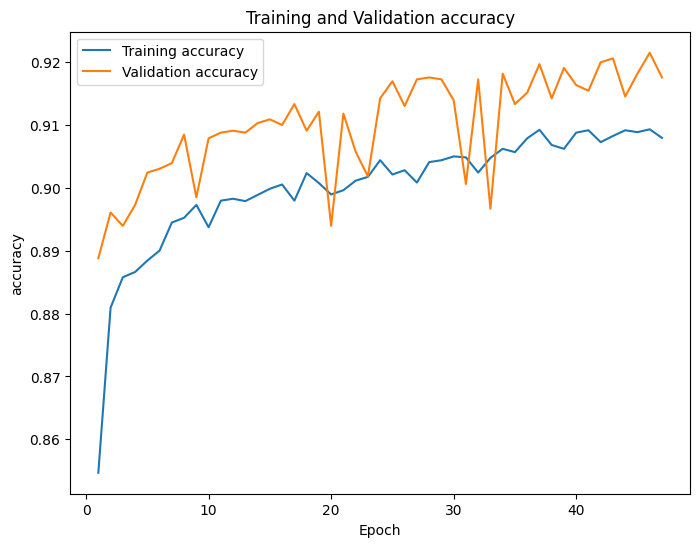

In [200]:
training_plots(history, 'accuracy')

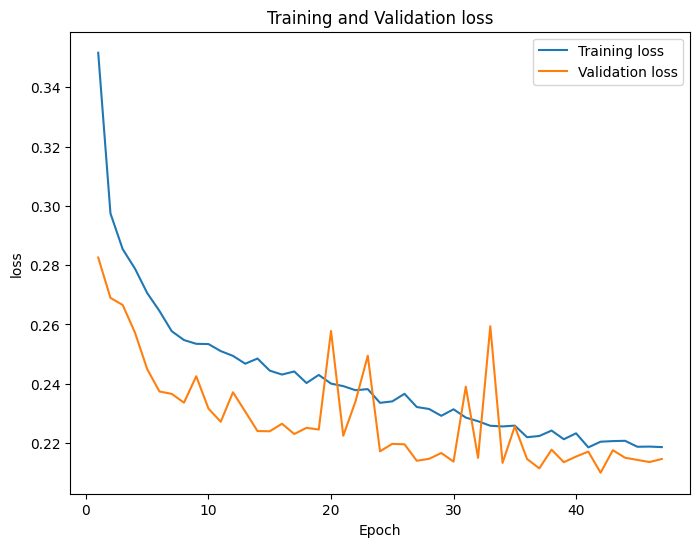

In [201]:
training_plots(history, 'loss')

In [202]:
loss, accuracy = tuned_classification_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Test Loss: 0.2053
Test accuracy: 0.9193


In [203]:
predictions = tuned_classification_model.predict(X_test_scaled)
threshold = 0.5
y_pred = np.where(predictions >= threshold, 1, 0)

129/129 [==============================] - 0s 600us/step


### Threshold tuning

In [204]:
thresh_arr = []
prec_arr = []
recall_arr = []
f1_arr = []
acc_arr = []

for i in range(11):
    thresh = .25 + i*.05
    thresh_arr.append(thresh)
    y_pred = np.where(predictions >= thresh, 1, 0)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec_arr.append(precision)
    recall_arr.append(recall)
    f1_arr.append(f1)
    acc_arr.append(acc)


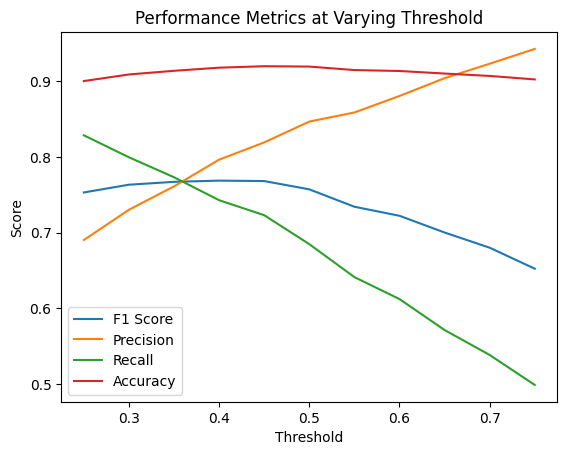

In [205]:
sns.lineplot(x=thresh_arr, y=f1_arr, label='F1 Score')
sns.lineplot(x=thresh_arr, y=prec_arr, label='Precision')
sns.lineplot(x=thresh_arr, y=recall_arr, label='Recall')
sns.lineplot(x=thresh_arr, y=acc_arr, label='Accuracy')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics at Varying Threshold')
plt.show()

Threshold of .5 appears to provide the best performance across all performance metrics

### Test performance on tuned model

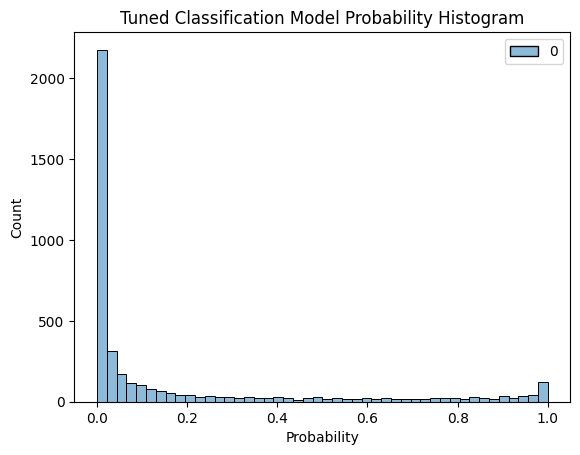

In [206]:
sns.histplot(predictions)
plt.title('Tuned Classification Model Probability Histogram')
plt.xlabel('Probability')
plt.show()

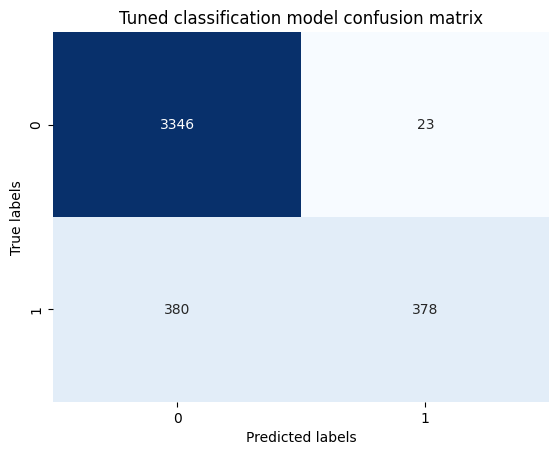

In [208]:
confusion_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned classification model confusion matrix')
plt.show()

In [209]:
print(f'Baseline classification model test accuracy: {baseline_acc:.4f}')
print(f'Tuned classification model test accuracy: {tuned_acc:.4f}\n')

print(f'Baseline classification model test precision: {baseline_precision:.4f}')
print(f'Tuned classification model test precision: {tuned_precision:.4f}\n')

print(f'Baseline classification model test recall: {baseline_recall:.4f}')
print(f'Tuned classification model test recall: {tuned_recall:.4f}\n')

print(f'Baseline classification model test F1: {baseline_f1:.4f}')
print(f'Tuned classification model test F1: {tuned_f1:.4f}')

Baseline classification model test accuracy: 0.9159
Tuned classification model test accuracy: 0.9198

Baseline classification model test precision: 0.8236
Tuned classification model test precision: 0.8280

Baseline classification model test recall: 0.6900
Tuned classification model test recall: 0.7111

Baseline classification model test F1: 0.7509
Tuned classification model test F1: 0.7651
